# Deep learning from scratch: homework 3

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `custom_plotter.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code.


- datasets for exercises: `noisy_sin_sample.csv`.

be sure you have these files located in the same directory where you put this notebook to work!

### When submitting this homework:
    
**Make sure all output is present in your notebook prior to submission**

#### <span style="color:#a50e3e;">Exercise 5. </span>  Implement the ``maxout`` activation function

So far we have seen various activation functions, most notably the tanh and relu functions defined below

\begin{array}
\
a(x) = \text{tanh}(w_0 + w_1x) \\
a(x) = \text{max}(0,w_0 + w_1x) \\
\end{array}

In this exercise you will implement the so-called [*maxout* activation](https://arxiv.org/pdf/1302.4389.pdf).  This function, defined as

\begin{array}
\
a(x) = \text{max}(v_0 + v_1s, \,w_0 + w_1x) \\
\end{array}

this activation takes maximum of two linear combinations of the input, instead of one linear combination and zero like the relu function.  While this change is algebraically rather minor, multilayer perceptron architectures employing the *maxout* activation tends to have certain advantages over those employing tanh and relu activations, including

- fewer issues with problematic initialization  e.g., values close too (or equal to) zero for the *relu* activation are bad because the relu is minimized at zero

- fewer issues with gradients vanishing or exploding, as can occur when using the tanh activation

- faster convergence with far fewer gradient descent steps

These advantages come with a simple price: the maxout activation has twice as many internal parameters as either the relu or tanh, hence architectures built with them have roughly twice as many parameters to tune.

You should implement this activation by appropriately adjusting the code blocks provided in the previous exercise.  In particular you should implement the activation with an input / activation output distribution normalized architecture. 

The necessary code block adjustments include

- changing the nonlinearity used in the function ``activation``


- adjusting the weight initialization module ``initialize_network_weights`` so that instead of creating one random weight matrix per hidden layer, you create and store two random weight matrices of identical size


- everything else has been adjusted for you - this includes the ``compute_features_normalized``  and ``compute_features_normalized_testing`` modules 


- the general progression of code blocks, along with results from a run using the completed architecture, are provided for you below 

Test out your code using a 5 layer input / activation output normalized architecture with 10 units in each layer, and fit this using a maximum of 200 steps of *unnormalized* gradient descent to the noisy sinusoidal dataset - which is loaded in below.  Within this number of steps you should be able to achieve a Least Squares cost value of 0.5 or less. Use a steplength parameter $\alpha$ of the form $10^{-\gamma}$ where $\gamma$ is the smallest positive integer that produces convergence with your random initial set of weights.

**You should turn in:**
    
**1)** your adjusted code blocks
    
    
**2)** a cost function plot for your run of gradient descent that achieves the desired goal


**3)** a plot showing your tuned model - using the best weights you found from your descent run - fit to the data (this model should overfit the given data)


**Hint:**

Feel free to steal useful code chunks from the previous exercise!

In [62]:
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# import custom utilities and plotter
import custom_plotter as plotter

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Feel free to use the following ``gradient_descent`` function below for this exercise.

In [63]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

The dataset is loaded in below.

<IPython.core.display.Javascript object>


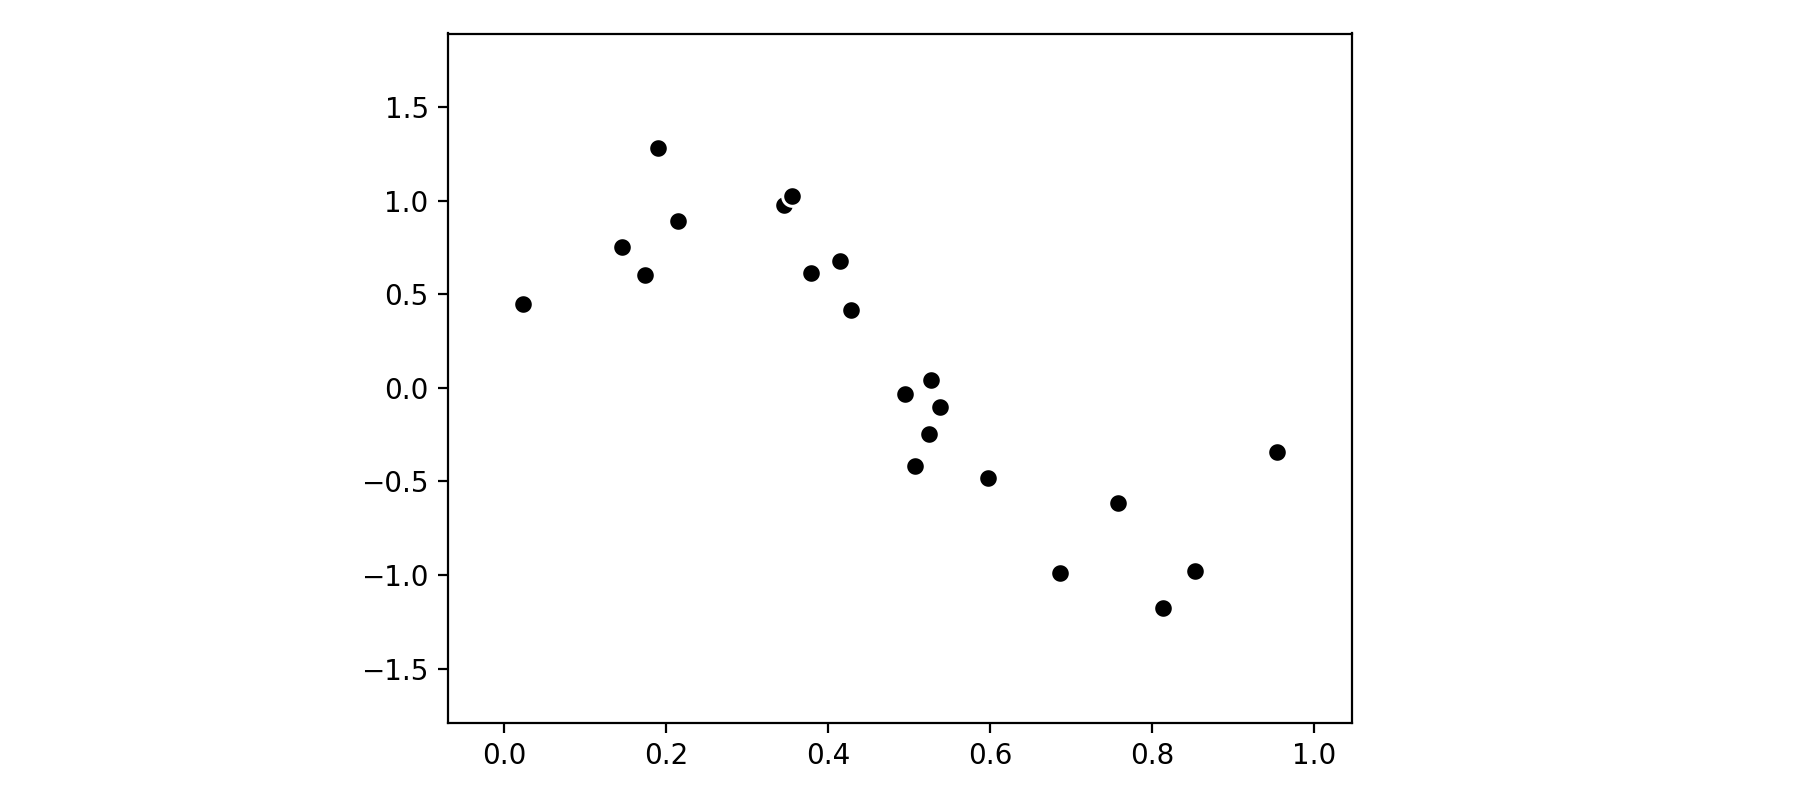

In [64]:
# load data
csvname = 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

# plot everything
plotter_demo = plotter.Visualizer()
plotter_demo.plot_regression_data(x,y)

Adjust the original weight initialization module to create twice as many internal weight matrices for the maxout activation.

In [73]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    ###### YOUR CODE GOES HERE ######
    weights=[]
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        wei_temp=[0,0]
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k + 1,U_k_plus_1)
        wei_temp[0]=weight
        weight = scale*np.random.randn(U_k + 1,U_k_plus_1)
        wei_temp[1]=weight
        weights.append(wei_temp)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init[1] = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1][0]]
    return w_init

Construct the desired network.

In [74]:
# A 5 layer network architecture
N = np.shape(x)[1]
M = np.shape(y)[1]
U_1 = 10                # number of units in layer 1
U_2 = 10                # number of units in layer 2
U_3 = 10                # number of units in layer 3
U_4 = 10                # number of units in layer 4
U_5 = 10                # number of units in layer 5

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,U_5,M]

# generate initial weights for our network
w_init = initialize_network_weights(layer_sizes,scale = 0.5)

In [93]:
print(w_init)

[[[array([[ 0.62093518,  0.72332875, -0.39308771,  0.19347574, -0.08731947,
        -0.35564374,  0.18036451,  0.3488633 ,  0.0044502 , -0.11004156],
       [ 0.13101212, -1.10589114,  0.2944211 ,  0.40622483, -0.88702862,
         0.01121109, -0.41601171, -0.43683471, -0.42027506,  0.71993627]]), array([[-0.47691314,  0.22242988, -0.24285994,  0.88249202, -0.1498345 ,
        -0.02395216, -0.52685169,  0.50040794,  0.88256465,  0.25106567],
       [ 0.26543792,  0.2253701 , -0.28314942, -0.74774795,  0.837612  ,
         0.15131274, -0.35297647, -0.99571692, -0.2939705 ,  0.28417976]])], [array([[ 0.11123114, -0.11546049, -0.1711656 ,  0.31783277, -0.16669115,
        -0.2964808 , -0.987604  , -0.15711338,  0.18667865,  0.90039821],
       [-0.39989314,  0.37028928,  0.10900999,  0.69461086,  0.3079365 ,
         0.252566  , -0.02110882,  0.41390503,  0.49360908,  0.19829479],
       [-0.38751668,  0.97782564, -0.17841971,  0.10181384,  0.23746338,
        -0.53241205,  0.02176174,  1

Now lets normalize our input.

In [75]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [76]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

Define the activation function.

In [77]:
def activation(x1,x2):
    # maxout activation
    ##### YOUR CODE GOES HERE
    f=np.maximum(x1,x2)
    return f

Our normalized network architecture compute function.

In [78]:
def compute_features_normalized(x, inner_weights):
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x)[0],1))
    a_padded = np.concatenate((o,x),axis = 1)
        
    # loop through weights and update each layer of the network
    for W1,W2 in inner_weights:                                  ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
        # output of layer activation  
        a = activation(np.dot(a_padded,W1),np.dot(a_padded,W2))  ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
                
        ### normalize output of activation
        # compute the mean and standard deviation of the activation output distributions
        a_means = np.mean(a,axis = 0)
        a_stds = np.std(a,axis = 0)
        
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
    
    return a_padded

Our ``predict`` function for the normalized architecture, along with a least squares function.

In [86]:
# our predict function 
def predict_normalized(x,w):     
    # feature trasnsformations
    f = compute_features_normalized(x,w[0])
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

# least squares
least_squares_normalized = lambda w: np.sum((predict_normalized(x_normed,w) - y)**2)

Now we perform the same run of gradient descent with the desired parameters set.

In [87]:
# parameters of gradient descent
alpha = 10**(-3) ;  max_its = 200; beta = 0; 

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(least_squares_normalized,w_init,alpha,max_its,beta,version = 'unnormalized')
cost_history_1 = [least_squares_normalized(v) for v in weight_history_1]

With our run comoplete we can now examine its cost history to visualize just how quickly gradient descent fits our maxout-based normalized architecture to the sinusoidal dataset.  Note: we are plotting from iteration 20 to 200 here.

<IPython.core.display.Javascript object>


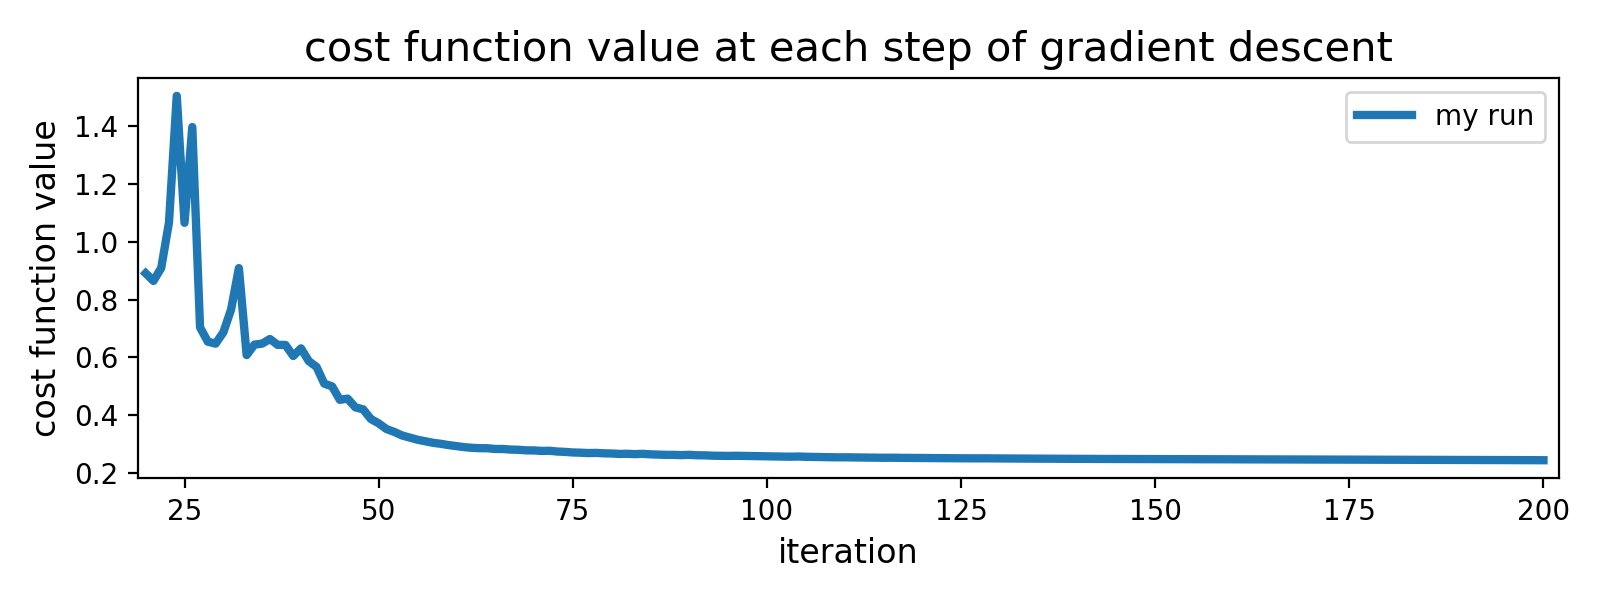

In [88]:
# plot the cost function history for our current run of gradient descent
histories = [cost_history_1]
labels = ['my run']
plotter_demo = plotter.Visualizer()
plotter_demo.compare_regression_histories(histories,start=20,labels=labels)

Now lets produce a plot of our fit to the dataset.

In [89]:
def compute_features_normalized_testing(x, inner_weights,stats):
    '''
    An adjusted normalized architecture compute function that collects network statistics as the training data
    passes through each layer, and applies them to properly normalize test data.
    '''
    # are you using this to compute stats on training data (stats empty) or to normalize testing data (stats not empty)
    switch =  'testing'
    if np.size(stats) == 0:
        switch = 'training'
        
    # if no stats given collect directly from input
    x_means = 0
    y_means = 0
    if switch == 'training':
        x_means = np.mean(x,axis = 0)
        x_stds = np.std(x,axis = 0)
        stats.append([x_means,x_stds])
    elif switch == 'testing':
        x_means = stats[0][0]
        x_stds = stats[0][1]

    # normalize input
    x_normed = normalize(x,x_means,x_stds)
    
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x_normed)[0],1))
    a_padded = np.concatenate((o,x_normed),axis = 1)
        
    # loop through weights and update each layer of the network
    c = 1
    for W1,W2 in inner_weights:                                    ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
        # output of layer activation
        a = activation(np.dot(a_padded,W1),np.dot(a_padded,W2))    ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
                
        ### normalize output of activation
        a_means = 0
        a_stds = 0
        if switch == 'training':
            # compute the mean and standard deviation of the activation output distributions
            a_means = np.mean(a,axis = 0)
            a_stds = np.std(a,axis = 0)
            stats.append([a_means,a_stds])
        elif switch == 'testing':
            a_means = stats[c][0]
            a_stds = stats[c][1]
            
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
        c+=1
    
    return a_padded,stats

Find the best weights according to our cost history, get training stats with respect to these weights.

In [90]:
# collect training normalization statistics for the final set of weights learned by gradient descent
best_ind = np.argmin(cost_history_1)
w1 = weight_history_1[best_ind]
a_padded,training_stats_1 = compute_features_normalized_testing(x,w1[0],[])

Now to use our ``compute_features_normalized_testing`` function on new test data we create a testing prediction function that calls it, which we call ``predict_testing``.

In [91]:
# our predict function 
def predict_testing_1(x,w):     
    # feature trasnsformations
    f,stats = compute_features_normalized_testing(x,w[0],training_stats_1)
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

Here was the associated fit I was able to get - quite a bit of overfitting here!

<IPython.core.display.Javascript object>


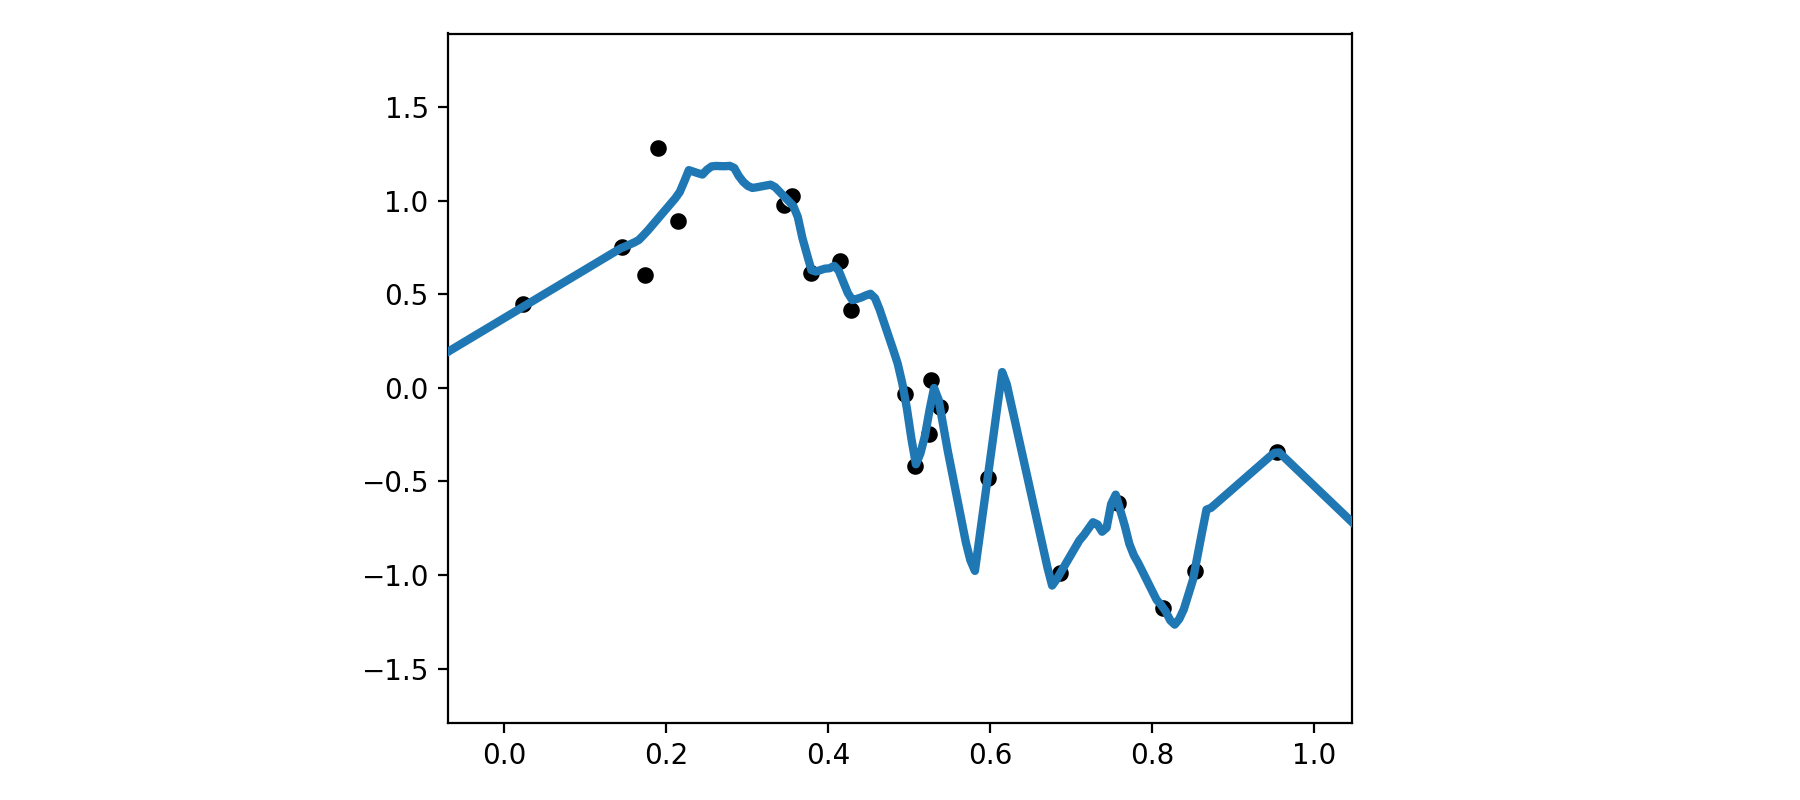

In [92]:
# compare final fits using unnormalized and normalized predictors
plotter_demo.plot_regression_data(x,y,predict = predict_testing_1,weights = w1)